# Counterfactual fairness: a law school "case study"

You've been asked to help a law school in the construction of a new admissions policy. The setting is as follows: the admissions office receives a batch of applications and has to decide which among the $M$ candidates to assign to the maximum of $N\ll M$ seats allocated to the incoming class. As part of the application process, each candidate submits their undergraduate GPA, LSAT score, and information relating to their race and gender. The head of admissions sent you the following e-mail:

> We have very high expectations for our students, so we try to identify candidates with the greatest ability to succeed in our law program. We can't measure it directly, but students with a high undergraduate GPA and LSAT score usually have what we're looking for.
>
> The dean was concerned about whether our admissions process was fair to underprivileged groups, who admittedly are not widely represented in the student body. However, we do not use a candidate's racial or gender identity in determining whether to admit them into the program. Our process is fairly simple: we rank each applicant according to the sum of their normalized undergraduate GPA and LSAT score, and we accept the highest ranked candidates until all of the seats for the incoming class are filled.
>
> I take our admissions process very seriously, so to assess the efficacy of our policy, the dean and I agreed to a small experiment over the past several years in which we admitted at random a few dozen candidates in each incoming class. I've sent over data on the students admitted as part of this experiment and their first year average grade in our law program. Could you please take a look and help in evaluating our admissions process?

Although the admissions policy does not make use of information on a candidate's race or gender in reaching a decision, you're concerned that this is inadequate. Students from less privileged backgrounds may lack the economic opportunity to enroll in LSAT preparation courses; classroom performance may not depend on ability alone but also be unduly affected by sensitive attributes that we do not want to use as a basis for admissions. Ignoring the admissions policy itself for a moment, you posulate the following causal process:

<img src="ls0.png" width="800">

Under this model, a candidate's ability -- which is unobserved -- is independent of their race and gender. However, given a candidate's undergraduate GPA, LSAT score, or their law school first-year average, ability is __not__ independent of either race or gender.

Let's be explicit about the role that the admissions policy plays in the model above. The current policy uses only a candidate's undergraduate GPA and LSAT score, and therefore does not depend directly on race or gender. As per the head of admissions' email, one way to measure the policy's effectiveness is to look at, e.g., the average grade among the admitted students in their first year in the law program (_"...with the greatest ability to succeed in our law program..."_). We can include the policy into the model as follows:

<img src="ls1.png" width="800">

Utility is how we measure the policy's performance, and therefore guides the construction of the policy itself. Our goal is to learn a policy which maximizes utility. This begs the question: what are characteristics of a "good" policy? Two particular criteria apply here:
- Screens for students with high ability.
- Doesn't discriminate on the basis of race, gender, etc.

How do we achieve these objectives? In other words, how can we express these goals more formally?

Let's return to the model above in which a candidate's admission into the program depends on their undergraduate GPA and LSAT score alone and in which we measure utility by the average first-year grade among admitted students. Although first-year average depends on ability, it does not depend on ability alone. Rather, it also carries information about a student's race and gender. Hence, by selecting students on the basis of projected high first-year average, we are necessarily selecting on the basis of race and gender (in addition to ability).

In other words, this utility function is not fairness-inducing. More generally, any utility function whose parents inlcude or descend from sensitive attributes __cannot__ be counterfactually fair with respect to those attributes.

<img src="ls2.png" width="800">

In [1]:
%matplotlib inline

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
class NaivePolicy:
    def __init__(self):
        pass
    def evaluate(self, G, L, nb_seats=None):
        assert G.shape == L.shape
        nb_obs = G.shape[0]
        if nb_seats is None:
            nb_seats = nb_obs
        else:
            assert isinstance(nb_seats, int) and (nb_seats > 0)
            nb_seats = min(nb_obs, nb_seats)
        ind = (normalize(G) + normalize(L)).argsort(axis=0)[-nb_seats:][::-1]
        P = np.zeros([nb_obs, 1]).astype(bool)
        P[ind] = True
        return P

class UnawarePolicy:
    def __init__(self):
        pass
    def train(self, G, L, F):
        self.F_reg = LinearRegression().fit(np.hstack([G, L]), F)
    def evaluate(self, G, L, nb_seats=None):
        assert G.shape == L.shape
        nb_obs = G.shape[0]
        if nb_seats is None:
            nb_seats = nb_obs
        else:
            assert isinstance(nb_seats, int) and (nb_seats > 0)
            nb_seats = min(nb_obs, nb_seats)
        F_hat = self.F_reg.predict(np.hstack([G, L]))
        ind = F_hat.argsort(axis=0)[-nb_seats:][::-1]
        P = np.zeros([nb_obs, 1]).astype(bool)
        P[ind] = True
        return P

class FairPolicy:
    def __init__(self):
        pass
    def train(self, R, S, G, L):
        self.G_reg = LinearRegression().fit(np.hstack([R, S]), G)
        self.L_reg = LinearRegression().fit(np.hstack([R, S]), L)
        G_err = G - self.G_reg.predict(np.hstack([R, S]))
        L_err = L - self.L_reg.predict(np.hstack([R, S]))
        self.A_reg = PCA(whiten=True, n_components=1).fit(np.hstack([G_err, L_err]))
        self.sgn = np.sign(np.corrcoef(self.A_reg.transform(np.hstack([G_err, L_err])).T, G.T)[0, 1])
    def evaluate(self, R, S, G, L, nb_seats=None):
        assert R.shape == S.shape == G.shape == L.shape
        nb_obs = R.shape[0]
        if nb_seats is None:
            nb_seats = nb_obs
        else:
            assert isinstance(nb_seats, int) and (nb_seats > 0)
            nb_seats = min(nb_obs, nb_seats)
        G_err = G - self.G_reg.predict(np.hstack([R, S]))
        L_err = L - self.L_reg.predict(np.hstack([R, S]))
        A_hat = self.sgn * self.A_reg.transform(np.hstack([G_err, L_err]))
        ind = A_hat.argsort(axis=0)[-nb_seats:][::-1]
        P = np.zeros([nb_obs, 1]).astype(bool)
        P[ind] = True
        return P

In [3]:
def normalize(x):
    return (x - np.mean(x)) / np.std(x)

def minmax_normalizer(df):
    return (df - df.min()) / (df.max() - df.min())

def simulate_exogenous_vars(nb_obs, R_pct=0.5, S_pct=0.5):
    assert isinstance(R_pct, float) and (0 <= R_pct <= 1)
    assert isinstance(S_pct, float) and (0 <= S_pct <= 1)
    R = 1. * (np.random.uniform(low=0, high=1, size=[nb_obs, 1]) < R_pct)
    S = 1. * (np.random.uniform(low=0, high=1, size=[nb_obs, 1]) < S_pct)
    A = np.random.randn(nb_obs, 1)
    return R, S, A

def simulate_endogenous_vars(A, R, S):
    assert A.shape == R.shape == S.shape
    nb_obs = A.shape[0]
    G = A + 2.1 * R + 3.3 * S + 0.5 * np.random.randn(nb_obs, 1)
    L = A + 5.8 * R + 0.7 * S + 0.1 * np.random.randn(nb_obs, 1)
    F = A + 2.3 * R + 1.0 * S + 0.3 * np.random.randn(nb_obs, 1)
    return G, L, F

def build_plot(P, A, R, S, G, L, F, colors=None, pc_samps=1000, figscale=6, fontsize=20):
    if colors is None:
        colors = {
            (0, 0): [(0.882, 0.529, 0.000, 1.000), (1.000, 0.647, 0.000, 0.500)],
            (1, 0): [(0.882, 0.000, 0.000, 1.000), (1.000, 0.000, 0.000, 0.500)],
            (0, 1): [(0.000, 0.882, 0.000, 1.000), (0.000, 1.000, 0.000, 0.500)],
            (1, 1): [(0.000, 0.000, 0.882, 1.000), (0.000, 0.000, 1.000, 0.500)]
        }
    gs = GridSpec(3, 4)
    gs.update(wspace=0, hspace=0)
    kwargs_hist = dict(bins=25, histtype='stepfilled', stacked=True)
    kwargs_text = dict(horizontalalignment='left', verticalalignment='top', fontsize=fontsize)
    fig = plt.figure(figsize=(4 * figscale, 3 * figscale))
    ax_dict = dict()
    for i, tup in enumerate(itertools.product([0, 1], [0, 1])):
        j, k = tup
        ind = (R == j) & (S == k)
        ax = fig.add_subplot(gs[j, k]) 
        ax.hist([A[ind & P], A[ind & ~P]], color=colors[tup], **kwargs_hist)
        ax.axvline(x=0, ls='dotted', color='black')
        ax.text(0.02, 0.98, 'R={0:}, S={1:}'.format(j, k), transform=ax.transAxes, **kwargs_text)
        ax.set_yticks([])
        ax.set_xlim([-5, 5])
        ax.set_xticks([])
        ax_dict[i] = ax
    ylim = [0, 1.05 * max([ax.get_ylim()[1] for ax in ax_dict.values()])]
    [ax.set_ylim(ylim) for ax in ax_dict.values()];
    ax = fig.add_subplot(gs[0:2, 2:])
    ax.hist([A[P], A[~P]], color=['darkgray', 'lightgray'], **kwargs_hist)
    ax.axvline(x=0, ls='dotted', color='black')
    ax.text(0.01, 0.99, 'All', transform=ax.transAxes, **kwargs_text)
    ax.set_yticks([])
    ax.set_xlim([-5, 5])
    ax.set_xticks([])
    ax = fig.add_subplot(gs[2:, 0:])
    z = ['A', 'G', 'L', 'F']
    x = range(len(z))
    df = pd.DataFrame({'A': A.flat, 'G': G.flat, 'L': L.flat, 'F': F.flat}, columns=z)
    df = minmax_normalizer(df)
    idx = np.random.choice(range(len(df)), pc_samps)
    colors = pd.DataFrame({'R': R.flat, 'S': S.flat}, columns=['R', 'S'])\
      .apply(tuple, axis=1).apply(lambda i: colors[i])
    for i in df.index[idx]:
        color = colors[i][0] if P[i] else colors[i][1]
        alpha = 0.500 if P[i] else 0.025
        ax.plot(x, df.loc[i], ls='solid', color=color, alpha=alpha)
    ax.set_ylim([0, 1])
    ax.set_xlim([x[0], x[-1]])
    ax.set_xticks(x)
    ax.set_xticklabels(z)
    [ax.axvline(x=_x, lw=1, ls='dotted', color='black') for _x in x];
    for tick in ax.yaxis.get_major_ticks():
        tick.label1On = False
        tick.tick1On = False
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize) 
    return fig

In [4]:
# generate some data
nb_obs = 100000
nb_seats = 20000
R, S, A = simulate_exogenous_vars(nb_obs, R_pct=0.75, S_pct=0.6) # simulate exogeous variables
G, L, F = simulate_endogenous_vars(A, R, S) # simulate endogenous variables

# set up naive policy
naivePolicy = NaivePolicy()

# set up and train unaware policy
unawarePolicy = UnawarePolicy()
unawarePolicy.train(G, L, F)

# set up and train fair policy
fairPolicy = FairPolicy()
fairPolicy.train(R, S, G, L)

# form policy dictionary
P = {
    'naive': naivePolicy.evaluate(G, L, nb_seats),
    'unaware': unawarePolicy.evaluate(G, L, nb_seats),
    'fair': fairPolicy.evaluate(R, S, G, L, nb_seats)
}

/Users/apedawi/Library/Python/2.7/lib/python/site-packages/pandas/core/dtypes/dtypes.py:271: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


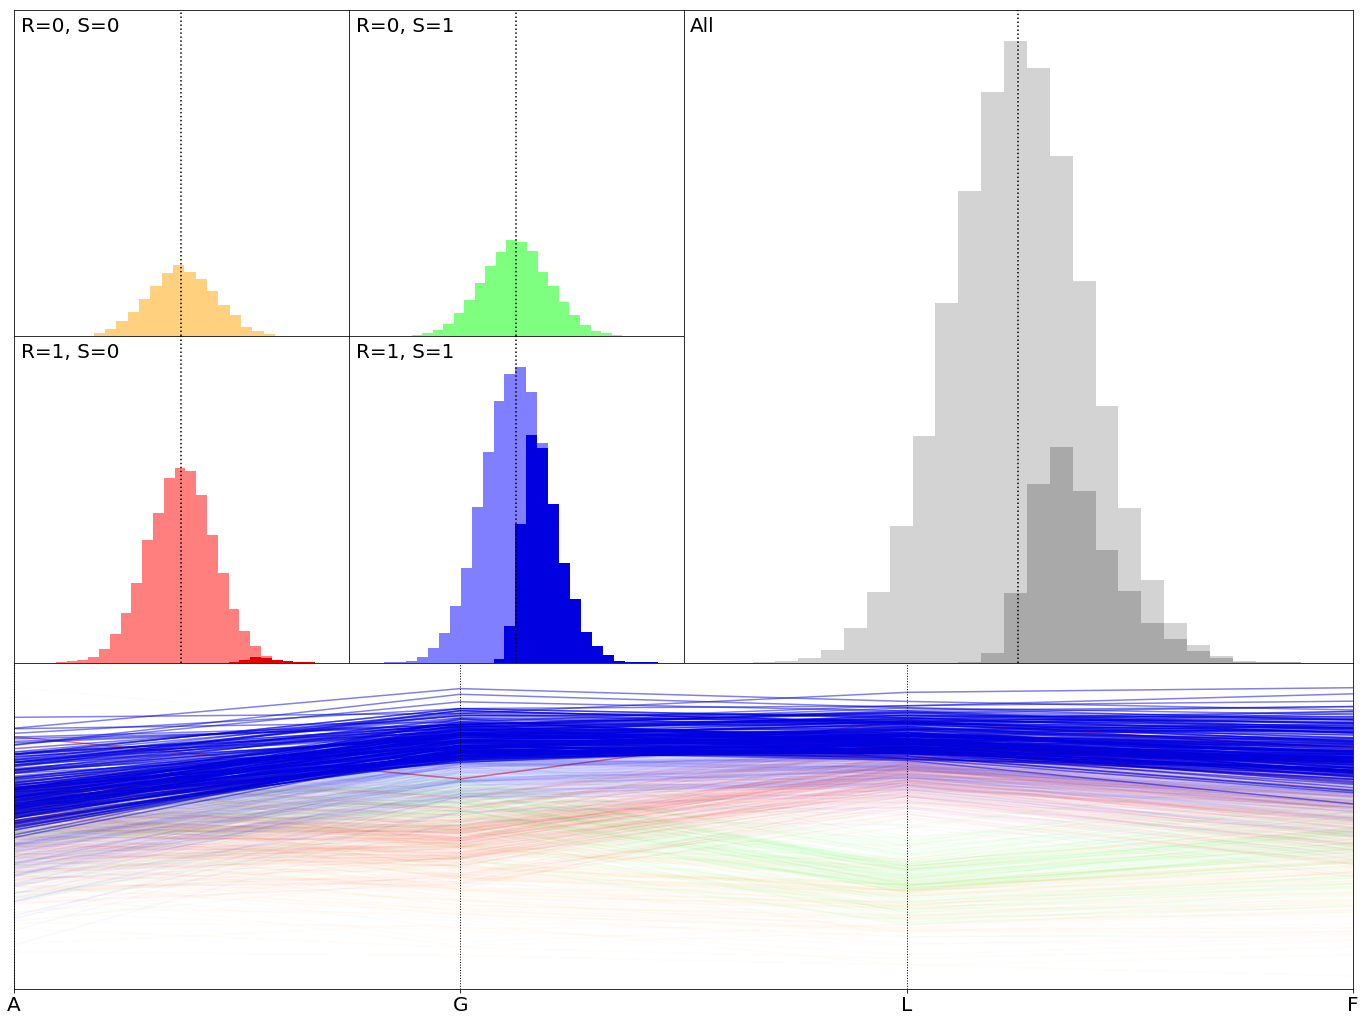

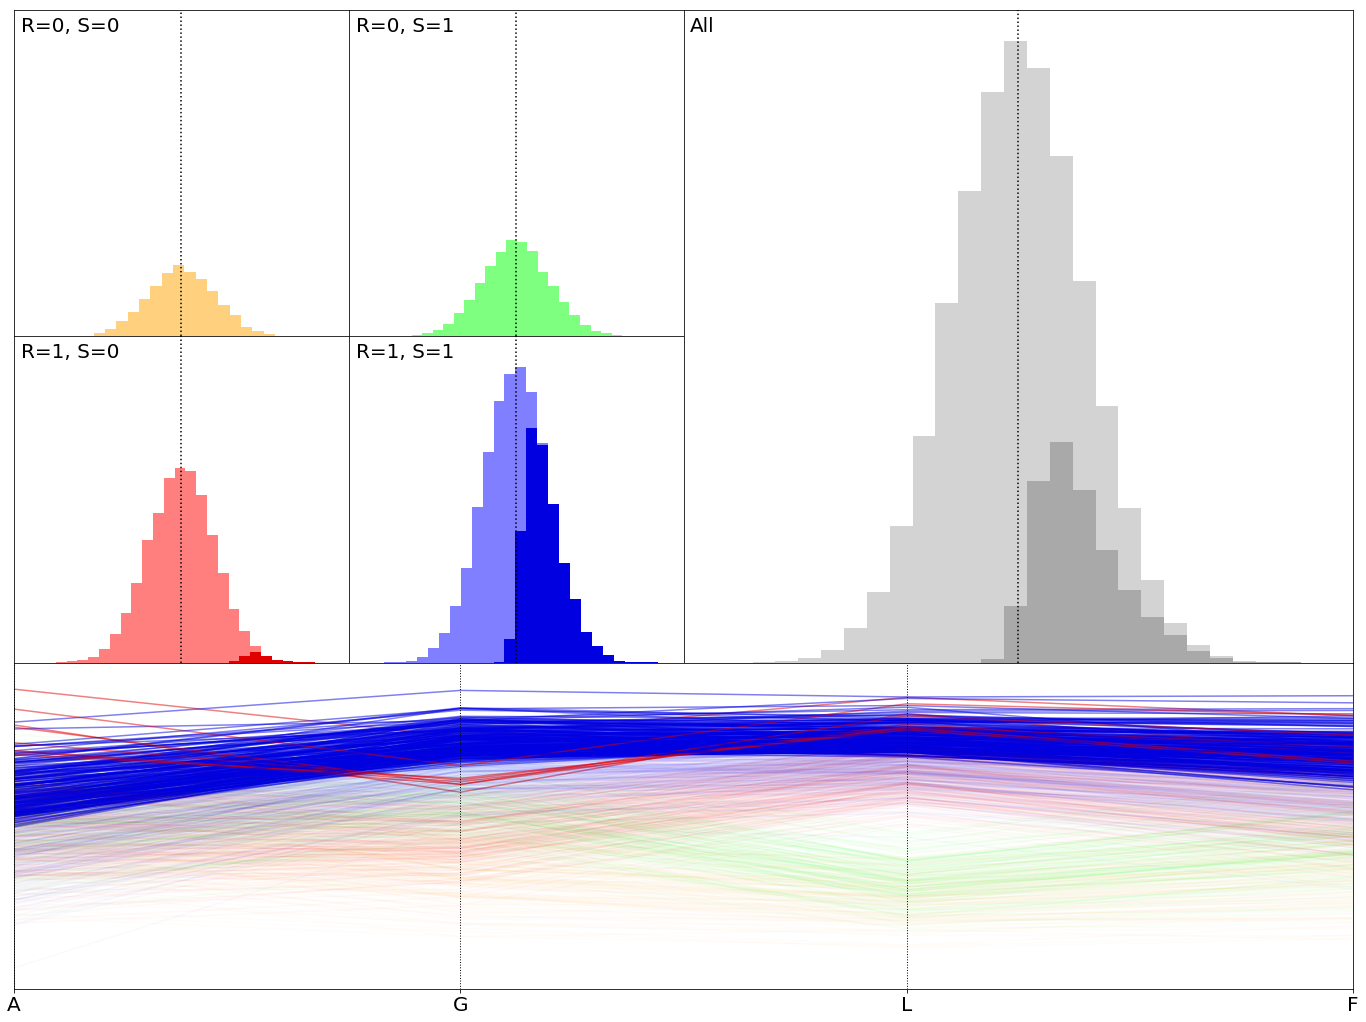

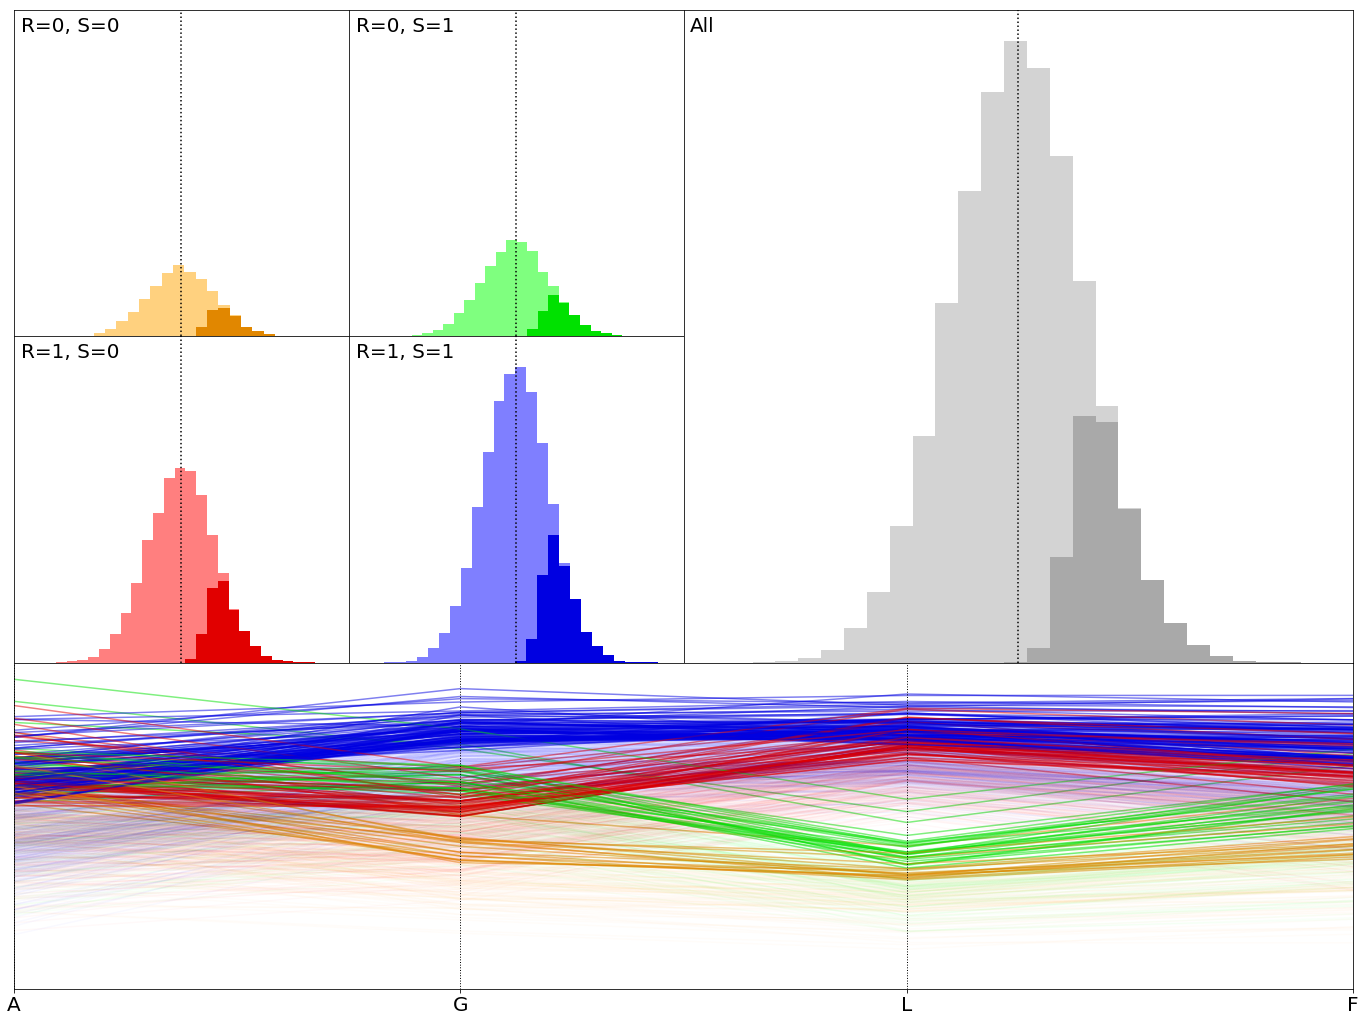

In [5]:
build_plot(P['naive'], A, R, S, G, L, F);
build_plot(P['unaware'], A, R, S, G, L, F);
build_plot(P['fair'], A, R, S, G, L, F);